In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import ParameterGrid

import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# **APPROACH 1**

2D convolution, 2 convolutional/pooling layers, filter size: 3x3, Max pooling, SGD optimizer, dropout, valid padding, fully connected layers width: 128

Hyperparameters: number of fully connected layers, epochs, learning rate

## datasets

In [14]:
# Paths to datasets
train_dir = "data/train"
test_dir = "data/test"

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(96, 96),
    batch_size=32,
    label_mode="int",  # Labels are integers (0 to 4)
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(96, 96),
    batch_size=32,
    shuffle=False,
    label_mode="int"
)

# Split training data into training and validation subsets
val_ds = train_ds.take(len(train_ds) // 5)  # use 20% for validation
train_ds = train_ds.skip(len(train_ds) // 5)


Found 6369 files belonging to 5 classes.
Found 2749 files belonging to 5 classes.


In [15]:
# Convert TensorFlow dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels


X_train, Y_train = dataset_to_numpy(train_ds)
X_val, Y_val = dataset_to_numpy(val_ds)
X_test, Y_test = dataset_to_numpy(test_ds)

print("X_train: ", X_train.shape, "\tY_train:", Y_train.shape)
print("X_val: ", X_val.shape, "\tY_val:", Y_val.shape)
print("X_test: ", X_test.shape, "\tY_test:", Y_test.shape)

2025-01-04 15:34:51.604578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train:  (5089, 96, 96, 3) 	Y_train: (5089,)
X_val:  (1280, 96, 96, 3) 	Y_val: (1280,)
X_test:  (2749, 96, 96, 3) 	Y_test: (2749,)


In [16]:
# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


## model

### training, hyperparameter tuning

In [6]:
def build_model(num_fc_layers=1, learning_rate=0.01):
    model = Sequential([
        Input(shape=(96, 96, 3)),
        # Convolutional layer
        Conv2D(32, (3, 3), activation='relu', padding='valid'),    # 32 filters, 3x3 kernel, valid padding
        # Pooling layer
        MaxPooling2D(pool_size=(2, 2)),  # MaxPooling
        
        # Convolutional layer
        Conv2D(64, (3, 3), activation='relu', padding='valid'),     # 64 filters
        # Pooling layer
        MaxPooling2D(pool_size=(2, 2)),  # MaxPooling
        
        # Flatten the output of the convolutional layers into a 1D vector
        Flatten(),
        
        # Fully connected layers
        *[Dense(128, activation='relu') for _ in range(num_fc_layers)],
        Dropout(0.5),  # Dropout regularization (50% of the neurons randomly dropped)
        
        Dense(5, activation='softmax')  # Output layer, 5 units (corresponding to the 5 actions)
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate),  # Stochastic Gradient Descent optimizer
              loss='sparse_categorical_crossentropy',  # Loss function
              metrics=['accuracy'])
    
    return model


# Hyperparameter grid
param_grid = {
    'num_fc_layers': [1, 6, 18],  # number of fully connected layers
    'learning_rate': [0.01, 0.001, 0.0001],  # learning rate
    'epochs': [10, 25, 60],  # epochs
}



# Perform the search
param_combinations = list(ParameterGrid(param_grid))
grid_search_results = []

print("Hyperparameter search:\n")
for i, params in enumerate(param_combinations):

    model = KerasClassifier(model=build_model, num_fc_layers=params['num_fc_layers'], learning_rate=params['learning_rate'], epochs=params['epochs'],  batch_size=32, verbose=1)

    # Perform the training (fit the model)
    grid_search_results.append({'params': params})

    model.fit(X_train, Y_train, verbose=0)  # Fit the model
    
    acc = model.score(X_val, Y_val)
    grid_search_results[i]['accuracy'] = acc

    print(f"Combination {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Accuracy: {acc}")
    print("-" * 50)    



# Save results for each combination of hyperparameters
df_results = pd.DataFrame(grid_search_results)
results_path = os.path.join(os.getcwd(), "results")
os.makedirs(results_path, exist_ok=True)
grid_results_file = os.path.join(results_path, 'grid_search_results_1.csv')
df_results.to_csv(grid_results_file, index=False)

# Get the best parameters
best_params = max(grid_search_results, key=lambda x: x['accuracy'])
print(f"\nBest Hyperparameters:\n{best_params}")

Hyperparameter search:

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Combination 1:
Parameters: {'epochs': 10, 'learning_rate': 0.01, 'num_fc_layers': 1}
Accuracy: 0.5546875
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Combination 2:
Parameters: {'epochs': 10, 'learning_rate': 0.01, 'num_fc_layers': 6}
Accuracy: 0.56171875
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Combination 3:
Parameters: {'epochs': 10, 'learning_rate': 0.01, 'num_fc_layers': 18}
Accuracy: 0.32109375
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Combination 4:
Parameters: {'epochs': 10, 'learning_rate': 0.001, 'num_fc_layers': 1}
Accuracy: 0.52890625
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Combination 5:
Parameters: {'epochs': 10, 'learning_rate': 0.001, 'num_fc_layers': 6}
Accuracy: 0.32109375
----------------------------------------

In [113]:
# Train the best model
best_model = build_model(num_fc_layers=best_params['params']['num_fc_layers'], learning_rate=best_params['params']['learning_rate'])
history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=best_params['params']['epochs'])

# Save the trained model
model_path = os.path.join(os.getcwd(), "model_1.keras")
best_model.save(model_path)
print(f"\nModel saved to {model_path}")

Epoch 1/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.3633 - loss: 1.4908 - val_accuracy: 0.4398 - val_loss: 1.3719
Epoch 2/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5383 - loss: 1.2773 - val_accuracy: 0.4633 - val_loss: 1.4214
Epoch 3/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5476 - loss: 1.2160 - val_accuracy: 0.4109 - val_loss: 1.5290
Epoch 4/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5445 - loss: 1.2171 - val_accuracy: 0.4297 - val_loss: 1.3129
Epoch 5/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5556 - loss: 1.1907 - val_accuracy: 0.5523 - val_loss: 1.1557
Epoch 6/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5693 - loss: 1.1486 - val_accuracy: 0.5648 - val_loss: 1.1548
Epoch 7/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5816 - loss: 1.1178 - val_accuracy: 0.4281 - val_loss: 1.3080
Epoch 8/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5524 - loss: 1.1480 - val

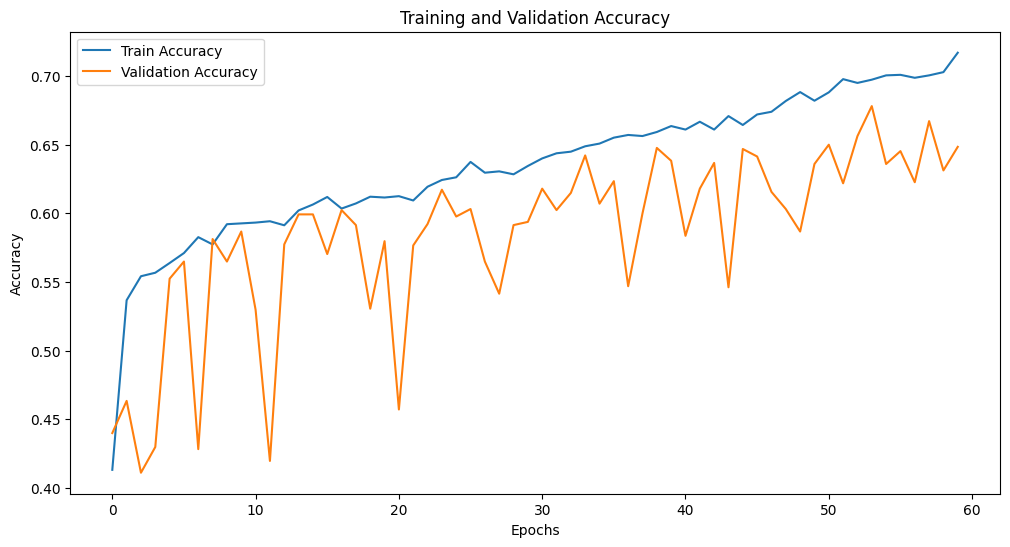

In [114]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### testing

In [17]:
model_path = os.path.join(os.getcwd(), "model_1.keras")
model = tf.keras.models.load_model(model_path)

def normalize(image, label):
    return image / 255.0, label
test_ds = test_ds.map(normalize)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Evaluate the model
# Accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Accuracy: {test_acc:.4f}")
# F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5926 - loss: 1.1792
Accuracy: 0.6319
F1-score: 0.6558
Precision: 0.7103
Recall: 0.6319


<Figure size 800x600 with 0 Axes>

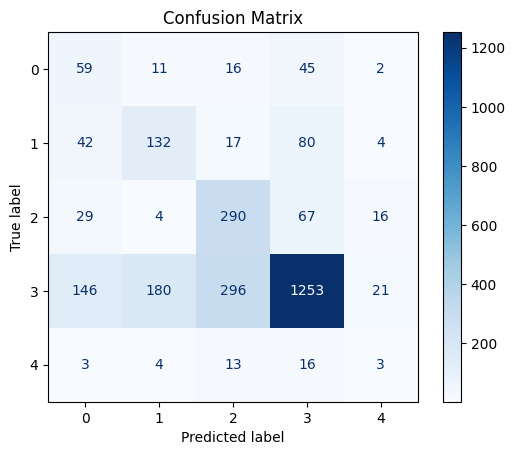

In [18]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
class_names = ['0', '1', '2', '3', '4']  # Replace with your class names if different

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


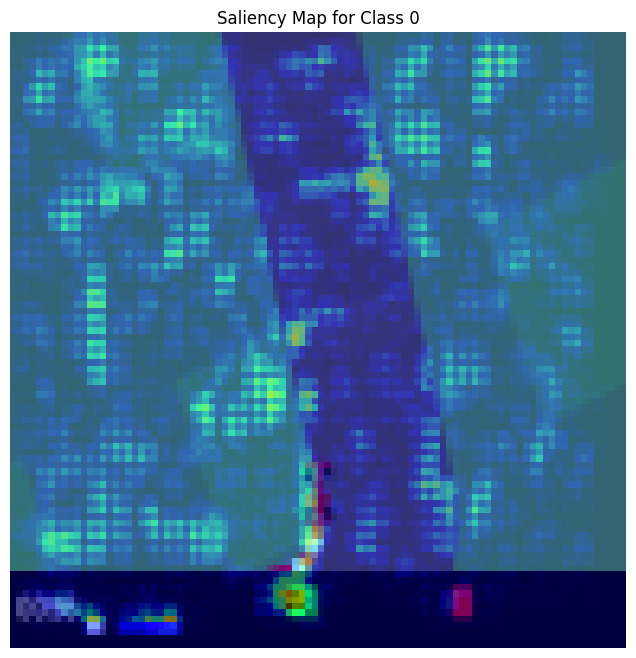

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


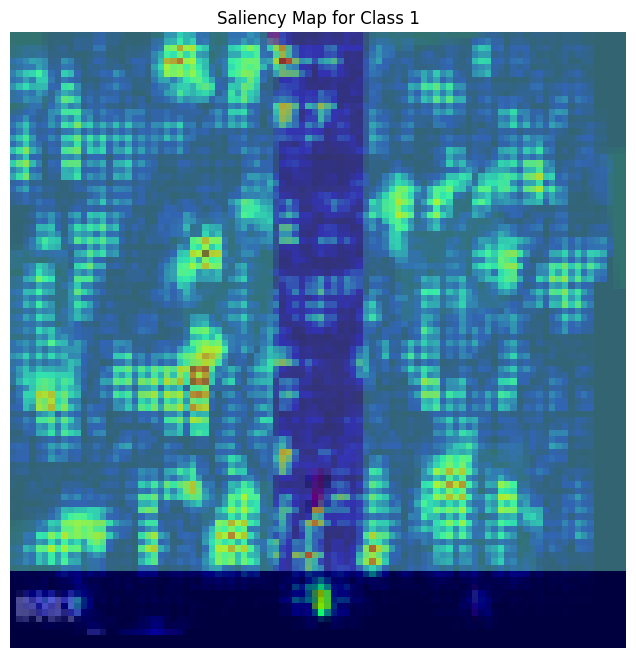

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


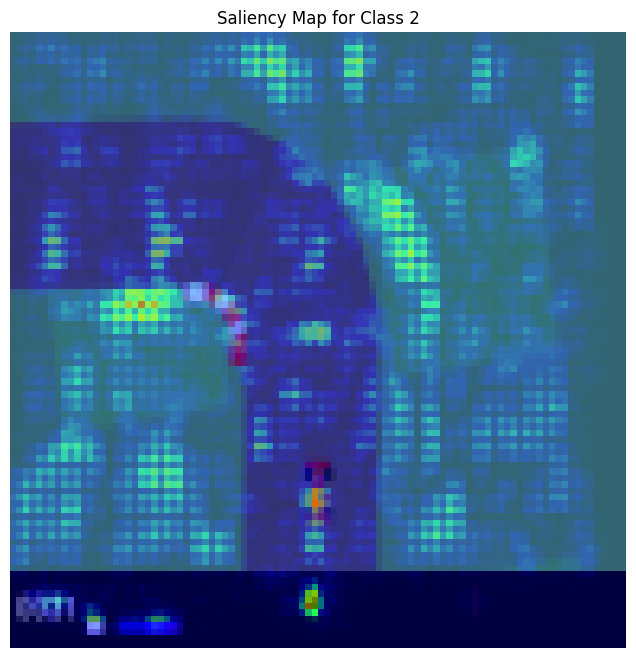

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


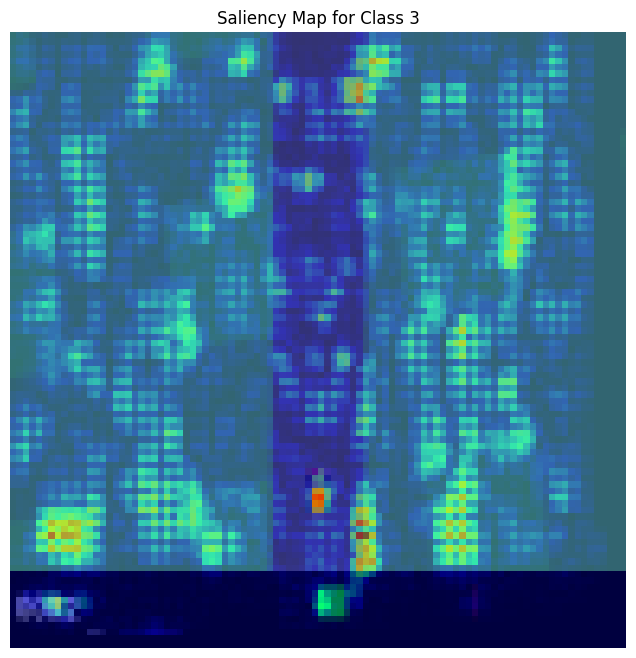

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


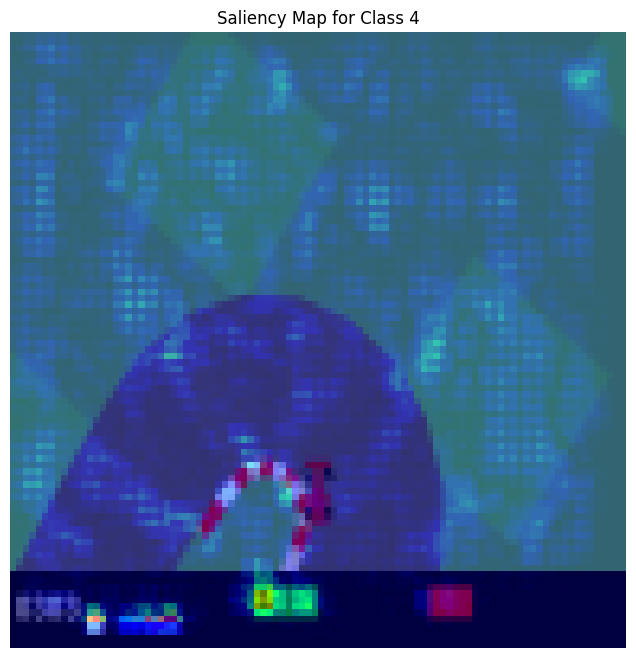

In [118]:
num_samples = sum(1 for _ in test_ds.unbatch())

# Find indices of one image for each class
found_classes = [0] * 5
idx = [-1] * 5
for i in range(num_samples):
    true_class = y_true[i]
    pred_class = y_pred[i]
    if found_classes[true_class] != 2:
        if true_class == pred_class:
            found_classes[true_class] = 2
        else:
            found_classes[true_class] = 1
        idx[true_class] = i


# Select a test image
for i in idx:
    test_image = X_test[i]
    test_image_batch = np.expand_dims(test_image, axis=0)
    # Convert to TensorFlow tensor
    test_image_batch = tf.convert_to_tensor(test_image_batch, dtype=tf.float32)

    # predicted class
    class_idx = np.argmax(model.predict(test_image_batch), axis=-1)[0]

    # gradient of the output for the predicted class w.r.t. the input image
    with tf.GradientTape() as tape:
        tape.watch(test_image_batch)  # Watch the input image
        prediction = model(test_image_batch)  # Forward pass
        class_output = prediction[:, class_idx]  # Get the predicted class score

    # Compute the gradient
    gradients = tape.gradient(class_output, test_image_batch)

    # Take the absolute value of gradients to get the saliency
    saliency = np.abs(gradients[0])  # Remove batch dimension

    # Normalize the saliency map for visualization
    saliency = saliency / np.max(saliency)

    # Plot the original test image and the saliency map overlayed
    plt.figure(figsize=(8, 8))
    plt.imshow(test_image)  # Original image
    plt.imshow(np.mean(saliency, axis=-1), cmap='jet', alpha=0.5)  # Saliency map overlay
    plt.title(f'Saliency Map for Class {y_true[i]}')
    plt.axis('off')
    plt.show()


 # **APPROACH 2**

2D convolution, 4 convolutional/pooling layers, filter size: 5x5, Average pooling, Adam optimizer, L2 regularization, data augmentation, same padding, fully connected layers width: 64

Hyperparameters: number of fully connected layers, epochs, regularization strength

## datasets

In [25]:
# Paths to datasets
train_dir = "data/train"
test_dir = "data/test"

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(96, 96),
    batch_size=32,
    label_mode="int",  # Labels are integers (0 to 4)
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(96, 96),
    batch_size=32,
    shuffle = False,
    label_mode="int"
)

# Split training data into training and validation subsetsa
val_ds = train_ds.take(len(train_ds) // 5)  # use 20% for validation
train_ds = train_ds.skip(len(train_ds) // 5)


Found 6369 files belonging to 5 classes.
Found 2749 files belonging to 5 classes.


In [26]:
# Normalize
def normalize(image, label):
    return image / 255.0, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

 ## model

### training, hyperparameter tuning

In [9]:
# data augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])


def build_model(num_fc_layers=1, regularization_strength=0.001):
    model = Sequential([
        Input(shape=(96, 96, 3)),

        data_augmentation,  # Data augmentation layer

        # Convolutional layer
        Conv2D(16, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),    # 16 filters, 5x5 kernel, same padding
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling
        
        # Convolutional layer
        Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),     # 32 filters
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling

        # Convolutional layer
        Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),    # 64 filters
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling
        
        # Convolutional layer
        Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),     # 128 filters
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling
        
        # Flatten the output of the convolutional layers into a 1D vector
        Flatten(),
        
        # Fully connected layers
        *[Dense(64, activation='relu', kernel_regularizer=l2(regularization_strength)) for _ in range(num_fc_layers)],
        
        Dense(5, activation='softmax')  # Output layer, 5 units (corresponding to the 5 actions)
    ])

    model.compile(optimizer=Adam(),  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Loss function
              metrics=['accuracy'])
    
    return model


# Hyperparameter grid
param_grid = {
    'num_fc_layers': [1, 6, 18],  # number of fully connected layers
    'regularization_strength': [0.01, 0.001, 0.0001],  # regularization strength
    'epochs': [10, 25, 60],  # epochs
}



# Perform the search
param_combinations = list(ParameterGrid(param_grid))
grid_search_results = []

print("Hyperparameter search:\n")
for i, params in enumerate(param_combinations):

    model = build_model(num_fc_layers=params['num_fc_layers'], regularization_strength=params['regularization_strength'])

    # Perform the training (fit the model)
    grid_search_results.append({'params': params})

    history = model.fit(train_ds, validation_data=val_ds, epochs=params['epochs'], verbose=0)

    
    # Accuracy
    acc = history.history['val_accuracy'][-1]
    grid_search_results[i]['accuracy'] = acc

    # F1 score
    y_p = np.argmax(model.predict(val_ds), axis=-1)
    f1 = f1_score(np.concatenate([y for _, y in val_ds], axis=0), y_p, average='weighted')
    grid_search_results[i]['f1_score'] = f1

    print(f"Combination {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Accuracy: {acc}")
    print(f"F1-score: {f1}")
    print("-" * 50)    



# Save results for each combination of hyperparameters
df_results = pd.DataFrame(grid_search_results)
results_path = os.path.join(os.getcwd(), "results")
os.makedirs(results_path, exist_ok=True)
grid_results_file = os.path.join(results_path, 'grid_search_results_2.csv')
df_results.to_csv(grid_results_file, index=False)

# Get the best parameters
best_params = max(grid_search_results, key=lambda x: (x['accuracy']*0.2 + x['f1_score']*0.8))
print(f"\nBest Hyperparameters:\n{best_params}")

Hyperparameter search:

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 1:
Parameters: {'epochs': 10, 'num_fc_layers': 1, 'regularization_strength': 0.01}
Accuracy: 0.41874998807907104
F1-score: 0.22575863517836012
--------------------------------------------------


2025-01-03 18:13:58.028455: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Combination 2:
Parameters: {'epochs': 10, 'num_fc_layers': 1, 'regularization_strength': 0.001}
Accuracy: 0.46406251192092896
F1-score: 0.2361888925755647
--------------------------------------------------


2025-01-03 18:16:12.991480: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 3:
Parameters: {'epochs': 10, 'num_fc_layers': 1, 'regularization_strength': 0.0001}
Accuracy: 0.4000000059604645
F1-score: 0.22076143796722256
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 4:
Parameters: {'epochs': 10, 'num_fc_layers': 6, 'regularization_strength': 0.01}
Accuracy: 0.3101562559604645
F1-score: 0.15210033382789317
--------------------------------------------------


2025-01-03 18:20:45.644161: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Combination 5:
Parameters: {'epochs': 10, 'num_fc_layers': 6, 'regularization_strength': 0.001}
Accuracy: 0.3148437440395355
F1-score: 0.1514400237529691
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Combination 6:
Parameters: {'epochs': 10, 'num_fc_layers': 6, 'regularization_strength': 0.0001}
Accuracy: 0.39765626192092896
F1-score: 0.18944080772175323
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Combination 7:
Parameters: {'epochs': 10, 'num_fc_layers': 18, 'regularization_strength': 0.01}
Accuracy: 0.30390626192092896
F1-score: 0.1501226218787158
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 8:
Parameters: {'epochs': 10, 'num_fc_layers': 18, 'regularization_strength': 0.001}
Accuracy: 0.30781251192092896
F1-score: 0.1514400237529691
--------------------------------------------------


2025-01-03 18:30:16.940877: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Combination 9:
Parameters: {'epochs': 10, 'num_fc_layers': 18, 'regularization_strength': 0.0001}
Accuracy: 0.31640625
F1-score: 0.15276171411625147
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 10:
Parameters: {'epochs': 25, 'num_fc_layers': 1, 'regularization_strength': 0.01}
Accuracy: 0.31718748807907104
F1-score: 0.1540876777251185
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Combination 11:
Parameters: {'epochs': 25, 'num_fc_layers': 1, 'regularization_strength': 0.001}
Accuracy: 0.3140625059604645
F1-score: 0.14880952380952378
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 12:
Parameters: {'epochs': 25, 'num_fc_layers': 1, 'regularization_strength': 0.0001}
Accuracy: 0.5
F1-score: 0.2196178398917353
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/

2025-01-03 19:12:01.149099: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Combination 17:
Parameters: {'epochs': 25, 'num_fc_layers': 18, 'regularization_strength': 0.001}
Accuracy: 0.31562501192092896
F1-score: 0.1514400237529691
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Combination 18:
Parameters: {'epochs': 25, 'num_fc_layers': 18, 'regularization_strength': 0.0001}
Accuracy: 0.30937498807907104
F1-score: 0.1514400237529691
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Combination 19:
Parameters: {'epochs': 60, 'num_fc_layers': 1, 'regularization_strength': 0.01}
Accuracy: 0.3140625059604645
F1-score: 0.15210033382789317
--------------------------------------------------
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Combination 20:
Parameters: {'epochs': 60, 'num_fc_layers': 1, 'regularization_strength': 0.001}
Accuracy: 0.5882812738418579
F1-score: 0.24663787119617844
--------------------------------------------------
40/40 ━━━━

In [27]:
# data augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])


def build_model(num_fc_layers=1, regularization_strength=0.001):
    model = Sequential([
        Input(shape=(96, 96, 3)),

        data_augmentation,  # Data augmentation layer

        # Convolutional layer
        Conv2D(16, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),    # 16 filters, 5x5 kernel, same padding
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling
        
        # Convolutional layer
        Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),     # 32 filters
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling

        # Convolutional layer
        Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),    # 64 filters
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling
        
        # Convolutional layer
        Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(regularization_strength)),     # 128 filters
        # Pooling layer
        AveragePooling2D(pool_size=(2, 2)),  # AveragePooling
        
        # Flatten the output of the convolutional layers into a 1D vector
        Flatten(),
        
        # Fully connected layers
        *[Dense(64, activation='relu', kernel_regularizer=l2(regularization_strength)) for _ in range(num_fc_layers)],
        
        Dense(5, activation='softmax')  # Output layer, 5 units (corresponding to the 5 actions)
    ])

    model.compile(optimizer=Adam(),  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Loss function
              metrics=['accuracy'])
    
    return model


best_params = {'params': {'epochs': 60, 'num_fc_layers': 1, 'regularization_strength': 0.001}, 'accuracy': 0.5882812738418579, 'f1_score': 0.24663787119617844}

In [28]:
# Train the best model
best_model = build_model(num_fc_layers=best_params['params']['num_fc_layers'], regularization_strength=best_params['params']['regularization_strength'])
history = best_model.fit(train_ds, validation_data=val_ds, epochs=best_params['params']['epochs'])

# Save the trained model
model_path = os.path.join(os.getcwd(), "model_2.keras")
best_model.save(model_path)
print(f"\nModel saved to {model_path}")

Epoch 1/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.3007 - loss: 1.6420 - val_accuracy: 0.3234 - val_loss: 1.5315
Epoch 2/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.3148 - loss: 1.5189 - val_accuracy: 0.3203 - val_loss: 1.5249
Epoch 3/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.3161 - loss: 1.5063 - val_accuracy: 0.4273 - val_loss: 1.4697
Epoch 4/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.4032 - loss: 1.4620 - val_accuracy: 0.4187 - val_loss: 1.4551
Epoch 5/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.4083 - loss: 1.4625 - val_accuracy: 0.4508 - val_loss: 1.3880
Epoch 6/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.4232 - loss: 1.4328 - val_accuracy: 0.4680 - val_loss: 1.4065
Epoch 7/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.4385 - loss: 1.4152 - val_accuracy: 0.4250 - val_loss: 1.4191
Epoch 8/60
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.4312 - loss: 1.4141 - 

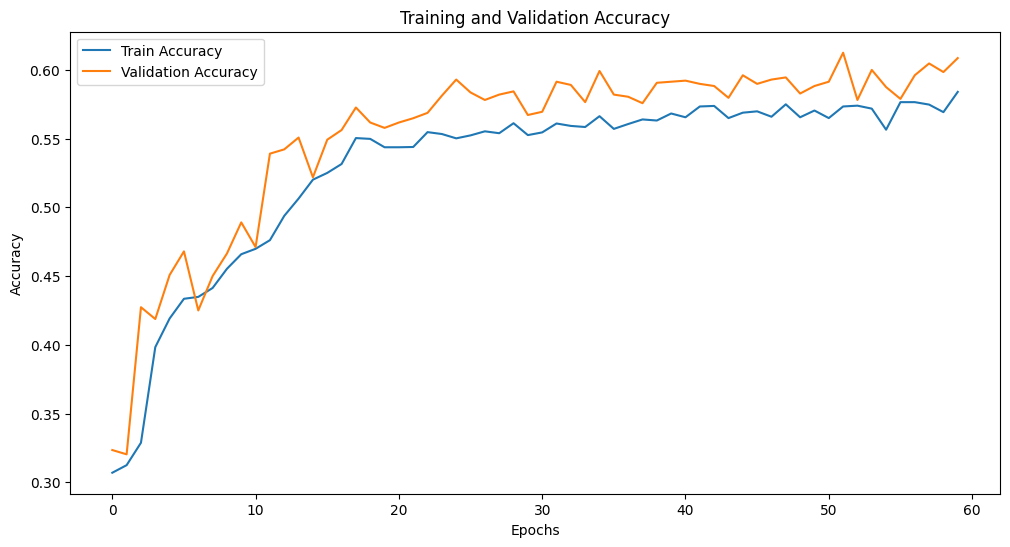

In [31]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### testing

In [7]:
model_path = os.path.join(os.getcwd(), "model_2.keras")
model = tf.keras.models.load_model(model_path)


y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Evaluate the model
# Accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Accuracy: {test_acc:.4f}")
# F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5901 - loss: 1.1672
Accuracy: 0.6402
F1-score: 0.6506
Precision: 0.7019
Recall: 0.6402


<Figure size 800x600 with 0 Axes>

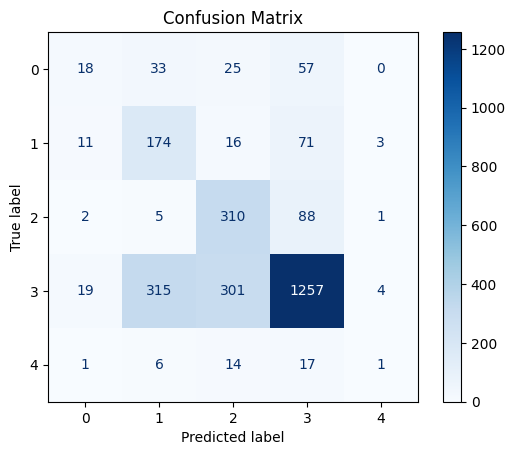

In [12]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
class_names = ['0', '1', '2', '3', '4']  # Replace with your class names if different

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


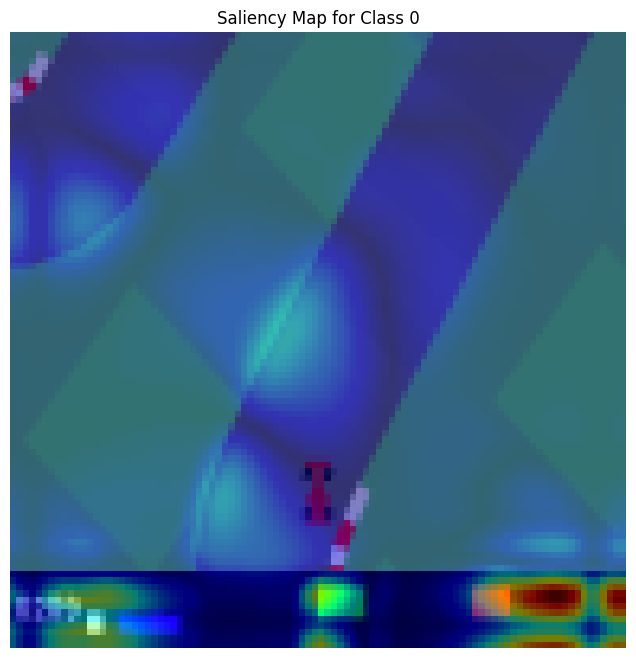

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


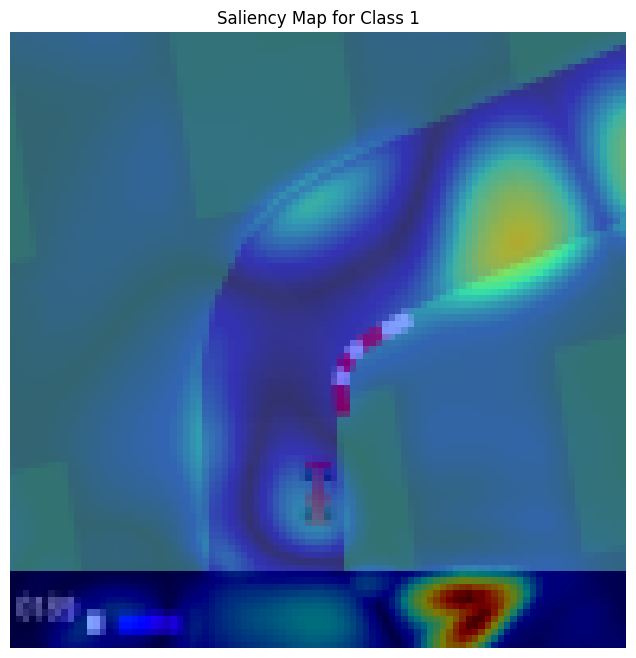

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


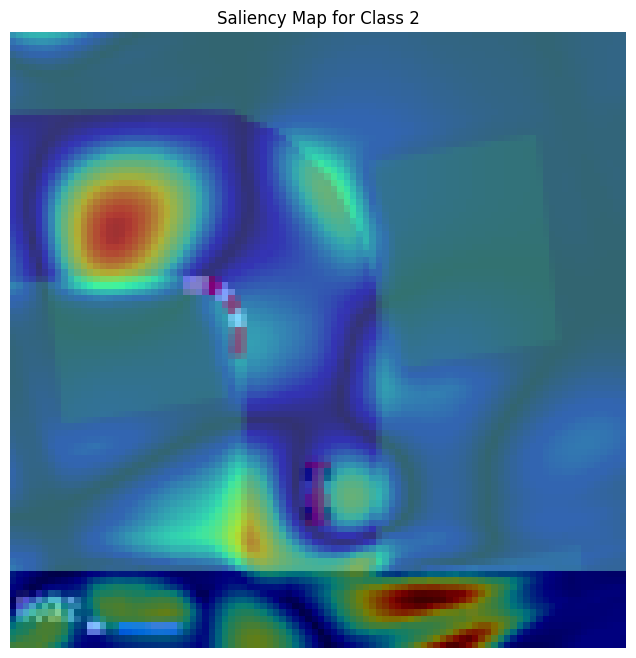

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


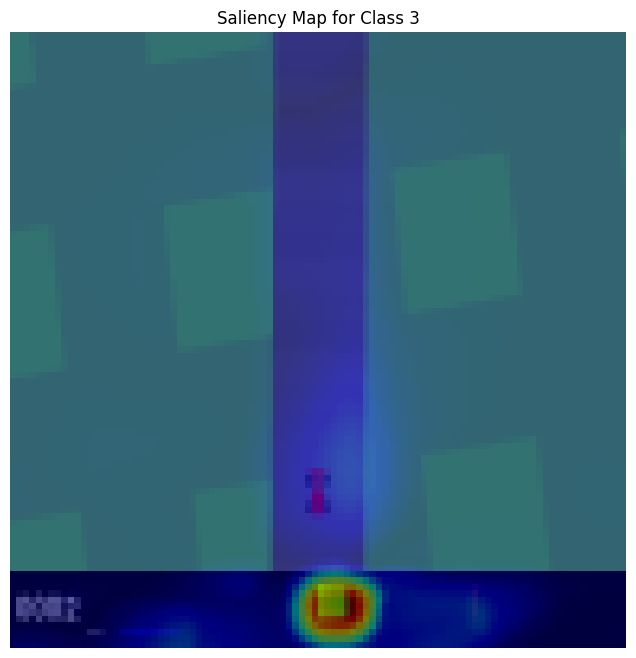

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


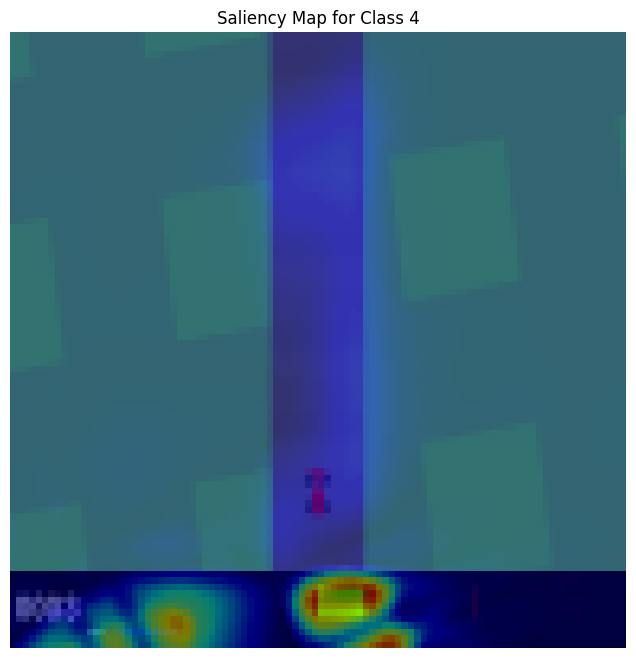

In [129]:
num_samples = sum(1 for _ in test_ds.unbatch())

# Find indices of one image for each class
found_classes = [0] * 5
idx = [-1] * 5
for i in range(num_samples):
    true_class = y_true[i]
    pred_class = y_pred[i]
    if found_classes[true_class] != 2:
        if true_class == pred_class:
            found_classes[true_class] = 2
        else:
            found_classes[true_class] = 1
        idx[true_class] = i


# Select a test image
for i in idx:
    test_image, label = list(test_ds.unbatch().skip(i).take(1).as_numpy_iterator())[0]
    test_image_batch = np.expand_dims(test_image, axis=0)
    # Convert to TensorFlow tensor
    test_image_batch = tf.convert_to_tensor(test_image_batch, dtype=tf.float32)

    # predicted class
    class_idx = np.argmax(model.predict(test_image_batch), axis=-1)[0]

    # gradient of the output for the predicted class w.r.t. the input image
    with tf.GradientTape() as tape:
        tape.watch(test_image_batch)  # Watch the input image
        prediction = model(test_image_batch)  # Forward pass
        class_output = prediction[:, class_idx]  # Get the predicted class score

    # Compute the gradient
    gradients = tape.gradient(class_output, test_image_batch)

    # Take the absolute value of gradients to get the saliency
    saliency = np.abs(gradients[0])  # Remove batch dimension

    # Normalize the saliency map for visualization
    saliency = saliency / np.max(saliency)

    # Plot the original test image and the saliency map overlayed
    plt.figure(figsize=(8, 8))
    plt.imshow(test_image)  # Original image
    plt.imshow(np.mean(saliency, axis=-1), cmap='jet', alpha=0.5)  # Saliency map overlay
    plt.title(f'Saliency Map for Class {y_true[i]}')
    plt.axis('off')
    plt.show()
